In [1]:
# import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# load the necessary files
filteredMatchDetails = pd.read_csv('../dataset/filteredMatchDetails.csv')
assistsMapDF = pd.read_csv('../dataset/assistsMap.csv', header=0)

In [3]:
filteredMatchDetails.columns

Index(['gameId', 'gameDuration', 'puuid', 'summonerId', 'teamId', 'win',
       'teamPosition', 'champExperience', 'kills', 'assists', 'turretKills',
       'epicMonsterKills', 'visionScore', 'visionWardsBoughtInGame',
       'magicDamageDealtToChampions', 'deaths', 'totalMinionsKilled',
       'timeCCingOthers', 'totalDamageTaken', 'totalHealsOnTeammates',
       'totalTimeSpentDead', 'goldEarned', 'objectivesStolen',
       'objectivesStolenAssists', 'participantId', 'participantsAssisted',
       'towerKillsAssisted', 'monsterKillsAssisted',
       'participantsAssistedWithPressure', 'queueType', 'tier', 'rank',
       'leaguePoints', 'matchPlayerCounts', 'summonerGamesPlayed', 'tierRank',
       'playerNumericalRank', 'matchAverageRank', 'teamAverageRank',
       'totalTeamGold', 'totalTeamGPM', 'totalTeamKills', 'totalTeamKPM',
       'totalTeamDeaths', 'totalTeamAssists', 'totalTeamAPM',
       'totalTeamEpicMonsterKills', 'totalTeamTurretKills',
       'totalTeamVisionScore', 't

In [4]:
playerIndegreeAndOutDegree = assistsMapDF[['gameId', 'teamId', 'teamPosition', 'playerTotalIndegree', 'playerTotalOutdegree']]
filteredMatchDetails = filteredMatchDetails.merge(playerIndegreeAndOutDegree, on=['gameId', 'teamId', 'teamPosition'], how='left')
filteredMatchDetails['playerTotalIndegree'].fillna(0, inplace=True)
filteredMatchDetails['playerTotalOutdegree'].fillna(0, inplace=True)

filteredMatchDetails['playerGoldPerMin'] = filteredMatchDetails['goldEarned'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerExpPerMin'] = filteredMatchDetails['champExperience'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerAssistsPerMin'] = filteredMatchDetails['assists'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerVisionScorePerMin'] = filteredMatchDetails['visionScore'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerMinionsKilledPerMin'] = filteredMatchDetails['totalMinionsKilled'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['intensity'] = filteredMatchDetails['assists'] / filteredMatchDetails['kills']

/tmp/ipykernel_106932/882792970.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filteredMatchDetails['playerTotalIndegree'].fillna(0, inplace=True)
/tmp/ipykernel_106932/882792970.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

## Perform variance inflation test and correlation test on set of features

In [5]:
# perform correlation tests
from patsy import dmatrices
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# using original set of metrics before, we had share of the match
playerPerformance_features = filteredMatchDetails[[   
                        'playerNumericalRank', 'goldEarned', 'playerGoldPerMin', 'champExperience', 'playerExpPerMin',
                        'kills', 'deaths', 'assists', 'playerAssistsPerMin', 'turretKills', 'epicMonsterKills',
                        'visionScore', 'playerVisionScorePerMin', 'totalMinionsKilled', 'playerMinionsKilledPerMin', 'playerTotalIndegree',
                        'playerTotalOutdegree'
                        ]]

correlation_matrix = playerPerformance_features.corr()

# Function to calculate p-values
def correlation_test(x, y):
    return stats.pearsonr(x, y)

# Calculating p-values
p_values = pd.DataFrame(index=playerPerformance_features.columns, columns=playerPerformance_features.columns)

for col1 in playerPerformance_features.columns:
    for col2 in playerPerformance_features.columns:
        if col1 == col2:
            p_values[col1][col2] = np.nan  # NaN for the diagonal
        else:
            corr_test = correlation_test(playerPerformance_features[col1], playerPerformance_features[col2])
            p_values[col1][col2] = corr_test[1]  # Extract the p-value

# print(p_values)

print("Correlation Matrix:")

correlation_matrix


/tmp/ipykernel_106932/3564625211.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  p_values[col1][col2] = np.nan  # NaN for the diagonal
/tmp/ipykernel_106932/3564625211.py:29: FutureWarning: ChainedAssignmentError: behaviour will change 

Correlation Matrix:


,playerNumericalRank,goldEarned,playerGoldPerMin,champExperience,playerExpPerMin,kills,deaths,assists,playerAssistsPerMin,turretKills,epicMonsterKills,visionScore,playerVisionScorePerMin,totalMinionsKilled,playerMinionsKilledPerMin,playerTotalIndegree,playerTotalOutdegree
playerNumericalRank,1.000000,-0.049398,0.151384,-0.131313,0.054942,-0.041809,-0.125854,0.045690,0.125423,0.007043,-0.007441,0.065457,0.127087,0.037093,0.105412,0.033014,0.016368
goldEarned,-0.049398,1.000000,0.754180,0.878146,0.675977,0.780388,0.081932,0.080682,-0.084369,0.484583,0.248804,-0.190465,-0.336087,0.512223,0.343628,0.718467,0.165393
playerGoldPerMin,0.151384,0.754180,1.000000,0.509341,0.775865,0.784295,-0.227843,-0.149644,-0.139117,0.555530,0.221528,-0.443036,-0.461840,0.471779,0.484147,0.699258,-0.079734
champExperience,-0.131313,0.878146,0.509341,1.000000,0.750892,0.534679,0.078591,0.135905,-0.066895,0.380469,0.234288,-0.140874,-0.314461,0.495967,0.304536,0.483397,0.214896
playerExpPerMin,0.054942,0.675977,0.775865,0.750892,1.000000,0.533312,-0.267166,-0.107003,-0.146030,0.478118,0.228561,-0.445245,-0.504177,0.521351,0.504186,0.452163,-0.036415
kills,-0.041809,0.780388,0.784295,0.534679,0.533312,1.000000,-0.006663,-0.046520,-0.110557,0.341857,0.224621,-0.229237,-0.291070,0.283703,0.213205,0.850818,0.025633
deaths,-0.125854,0.081932,-0.227843,0.078591,-0.267166,-0.006663,1.000000,0.010893,-0.108943,-0.167651,-0.094428,0.060748,-0.026352,-0.011447,-0.112999,-0.074633,-0.015955
assists,0.045690,0.080682,-0.149644,0.135905,-0.107003,-0.046520,0.010893,1.000000,0.947601,-0.072565,0.099613,0.553795,0.499828,-0.335105,-0.421631,0.070914,0.927979
playerAssistsPerMin,0.125423,-0.084369,-0.139117,-0.066895,-0.146030,-0.110557,-0.108943,0.947601,1.000000,-0.088888,0.074124,0.495845,0.516968,-0.405274,-0.432842,0.009661,0.863529
turretKills,0.007043,0.484583,0.555530,0.380469,0.478118,0.341857,-0.167651,-0.072565,-0.088888,1.000000,-0.029450,-0.212614,-0.239263,0.440406,0.418937,0.332060,0.005353


### VIF on player performance features

In [6]:
# Perform VIF test on player performance features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

# Add a constant for the intercept
X = sm.add_constant(playerPerformance_features)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data['features'] = playerPerformance_features.columns
vif_data['VIF'] = [ variance_inflation_factor(playerPerformance_features.values, i) for i in range(playerPerformance_features.shape[1]) ]

print(vif_data)

                     features          VIF
0         playerNumericalRank     6.869804
1                  goldEarned  2240.199242
2            playerGoldPerMin  2006.252555
3             champExperience  2181.086808
4             playerExpPerMin  2047.868932
5                       kills    19.616134
6                      deaths     6.092007
7                     assists   219.143419
8         playerAssistsPerMin   194.311294
9                 turretKills     2.795745
10           epicMonsterKills     3.341907
11                visionScore   128.209998
12    playerVisionScorePerMin   127.705620
13         totalMinionsKilled   226.484918
14  playerMinionsKilledPerMin   209.620839
15        playerTotalIndegree    15.560524
16       playerTotalOutdegree    33.808206


### Features set used -- `'playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'turretKills', 'epicMonsterKills'`

In [7]:
# VIF on selective set of columns removing gold earned related columns
features_subset = playerPerformance_features[['playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'playerGoldPerMin', 'playerNumericalRank']]

X = sm.add_constant(features_subset)

vif_data_v2 = pd.DataFrame()
vif_data_v2['features'] = features_subset.columns
vif_data_v2['VIF'] = [ variance_inflation_factor(features_subset.values, i) for i in range(features_subset.shape[1]) ] 

print(vif_data_v2)  

                  features        VIF
0          playerExpPerMin  75.258393
1  playerVisionScorePerMin   3.927482
2      playerTotalIndegree   5.279188
3     playerTotalOutdegree   6.157258
4         playerGoldPerMin  94.778079
5      playerNumericalRank   5.828854


### Scree analysis to detect number of factors

In [8]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

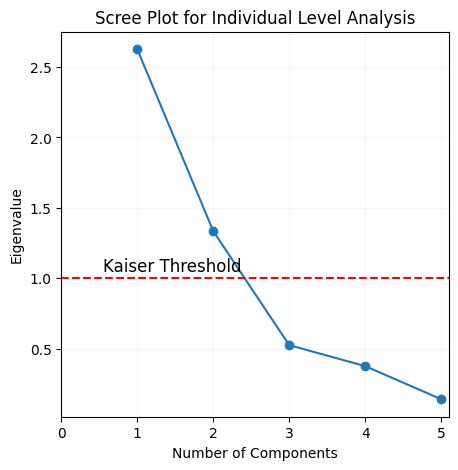

In [9]:
# scale features
features = playerPerformance_features[['playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'playerGoldPerMin']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled)


# Plot the Scree Plot
plt.figure(figsize=(5,5))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.55, 1.05, 'Kaiser Threshold', color='black', fontsize=12)
plt.title('Scree Plot for Individual Level Analysis')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.grid(axis='both', alpha=0.1)
plt.xlim(0, 5.1)
plt.show()

### KMO test to check for suitability of Factor analysis

In [10]:
# performing KMO test on the dataset to see if dataframe is suitable for factor analysis
from factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(features_scaled)

# Print the results
print(f"KMO Overall: {kmo_model:.4f}")

# If you want to see individual KMO values for each variable:
print("Individual KMO values:\n", kmo_all)

KMO Overall: 0.5833
Individual KMO values:
 [0.61213978 0.66586842 0.580817   0.35113372 0.59224798]


<span style="color:green;"> KMO Value of 0.58 is not good; but acceptable for factor analysis </span>

In [11]:
# Perform Factor Analysis
fa = FactorAnalysis(n_components=2, rotation='varimax', max_iter=2000)  # Adjust n_components based on Scree Plot; making the number of components as 2, because we dont see a good distinction of features with 3 latent factors
fa.fit(features_scaled)
factor_loadings = fa.components_.T

# factor loadings for each feature column
loadings_df = pd.DataFrame(factor_loadings, index=features.columns, columns=[f'Factor{i+1}' for i in range(factor_loadings.shape[1])])

# compute factor scores
factor_scores = fa.transform(features_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/decomposition/_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


### Using only 5 features, i.e. player gold per min instead of epic monster kills and turret takedowns, yields a better separation of factor and much more explanatory

In [12]:
loadings_df.rename(columns={'Factor1': 'AcquiringFactor', 'Factor2': 'SharingFactor'}, inplace=True)
loadings_df

,AcquiringFactor,SharingFactor
playerExpPerMin,0.722582,-0.329657
playerVisionScorePerMin,-0.267901,0.929751
playerTotalIndegree,0.707400,-0.043173
playerTotalOutdegree,0.030507,0.501338
playerGoldPerMin,0.974895,-0.215896


In [13]:
# rename columns for better understanding
factor_scores_df.rename(columns={'Factor1': 'AcquiringFactor', 'Factor2': 'SharingFactor'}, inplace=True)
factor_scores_df

,AcquiringFactor,SharingFactor
0,-0.773508,-0.220719
1,-0.264876,-0.238105
2,0.680857,0.011135
3,0.128600,-1.045854
4,-1.656852,0.776635
...,...,...
310545,1.836734,-0.323978
310546,0.209871,-0.502533
310547,0.230619,-0.044144
310548,0.467504,0.055701


In [14]:
## concatenate the factor scores df with the player performance features
win_info = filteredMatchDetails[['gameId', 'teamId', 'teamPosition', 'win']]
factors_with_win_info = pd.concat([win_info, playerPerformance_features, factor_scores_df], axis=1)
factors_with_win_info

,gameId,teamId,teamPosition,win,playerNumericalRank,goldEarned,playerGoldPerMin,champExperience,playerExpPerMin,kills,...,turretKills,epicMonsterKills,visionScore,playerVisionScorePerMin,totalMinionsKilled,playerMinionsKilledPerMin,playerTotalIndegree,playerTotalOutdegree,AcquiringFactor,SharingFactor
0,EUW1_7139824479,100,TOP,0,4,10434,335.678284,15998,514.680965,3,...,1,0,30,0.965147,149,4.793566,8,15,-0.773508,-0.220719
1,EUW1_7139824479,100,JUNGLE,0,4,11754,378.144772,12801,411.828418,5,...,0,0,25,0.804290,21,0.675603,14,18,-0.264876,-0.238105
2,EUW1_7139824479,100,MIDDLE,0,3,14008,450.659517,16812,540.868633,8,...,3,0,27,0.868633,224,7.206434,17,13,0.680857,0.011135
3,EUW1_7139824479,100,BOTTOM,0,5,13199,424.632708,13664,439.592493,9,...,1,1,5,0.160858,162,5.211796,26,7,0.128600,-1.045854
4,EUW1_7139824479,100,UTILITY,0,4,7658,246.369973,9087,292.343164,2,...,0,0,57,1.833780,25,0.804290,3,15,-1.656852,0.776635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310545,EUW1_7139963823,200,TOP,1,30,17358,551.631356,19157,608.802966,9,...,6,0,14,0.444915,267,8.485169,12,7,1.836734,-0.323978
310546,EUW1_7139963823,200,JUNGLE,1,30,13257,421.302966,13654,433.919492,12,...,1,2,17,0.540254,22,0.699153,32,9,0.209871,-0.502533
310547,EUW1_7139963823,200,MIDDLE,1,29,13058,414.978814,15165,481.938559,7,...,1,0,27,0.858051,216,6.864407,14,22,0.230619,-0.044144
310548,EUW1_7139963823,200,BOTTOM,1,31,13607,432.425847,17052,541.906780,4,...,2,0,29,0.921610,262,8.326271,12,19,0.467504,0.055701


# Fitting and Prediction Using Individual Level Game Metrics

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
# splitting games into train-test split; 
# we use an additional filter at the top to ensure that both train-test have same number number of win outcomes, sampling equally!

X = factors_with_win_info[['AcquiringFactor', 'SharingFactor']]
y = factors_with_win_info[['win']]

# perform startified sampling to ensure equal distribution of win outcomes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the distribution
print("Training set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

features_names = X_train.columns

Training set distribution:
win
0      0.5
1      0.5
Name: proportion, dtype: float64

Test set distribution:
win
0      0.5
1      0.5
Name: proportion, dtype: float64


### Binary Logistic Regression

In [17]:
# check for results with and without scaling
# Scaling data features to avoid model skewing; performing scaling may not be necessary, because we have transformed the data!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [18]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))
print(blr_feature_importances)

y_pred = model.predict(X_test)

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'AcquiringFactor': np.float64(1.0875826256202048), 'SharingFactor': np.float64(0.517866834628798)}


In [19]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.574463
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:               248440
Model:                          Logit   Df Residuals:                   248437
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Jan 2025   Pseudo R-squ.:                  0.1712
Time:                        20:24:15   Log-Likelihood:            -1.4272e+05
converged:                       True   LL-Null:                   -1.7221e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0249      0.005      5.480      0.000       0.016       0.034
AcquiringFacto

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'AcquiringFactor': np.float64(1.0875826256202048), 'SharingFactor': np.float64(0.517866834628798)}
Accuracy: 0.703574303654806
Confusion Matrix:
 [[22187  8868]
 [ 9543 21512]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71     31055
           1       0.71      0.69      0.70     31055

    accuracy                           0.70     62110
   macro avg       0.70      0.70      0.70     62110
weighted avg       0.70      0.70      0.70     62110



### Decision Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'AcquiringFactor': np.float64(0.5673321700401918), 'SharingFactor': np.float64(0.4326678299598083)}
Accuracy: 0.620286588311061
Confusion Matrix:
 [[19280 11775]
 [11809 19246]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62     31055
           1       0.62      0.62      0.62     31055

    accuracy                           0.62     62110
   macro avg       0.62      0.62      0.62     62110
weighted avg       0.62      0.62      0.62     62110



### Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'AcquiringFactor': np.float64(0.6255293290743831), 'SharingFactor': np.float64(0.3744706709256169)}
RF Accuracy: 0.7114796329093543
RF Confusion Matrix:
 [[21680  9375]
 [ 8545 22510]]
RF Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71     31055
           1       0.71      0.72      0.72     31055

    accuracy                           0.71     62110
   macro avg       0.71      0.71      0.71     62110
weighted avg       0.71      0.71      0.71     62110



### XG Boosting

In [23]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

{'AcquiringFactor': np.float32(0.8081245), 'SharingFactor': np.float32(0.1918755)}
XGB Accuracy: 0.7111576235710836
XGB Confusion Matrix:
 [[21460  9595]
 [ 8345 22710]]
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.71     31055
           1       0.70      0.73      0.72     31055

    accuracy                           0.71     62110
   macro avg       0.71      0.71      0.71     62110
weighted avg       0.71      0.71      0.71     62110



In [ ]:
# Store the feature importance values of each model into a dataframe
data = {
    'Model Name': ['Binary Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'ri_AcquiringFactor': [
        float(blr_feature_importances['AcquiringFactor']),
        float(feature_importances['AcquiringFactor']),
        float(rf_feature_importances['AcquiringFactor']),
        float(xgb_feature_importances['AcquiringFactor'])
    ],
    'ri_SharingFactor': [
        float(blr_feature_importances['SharingFactor']),
        float(feature_importances['SharingFactor']),
        float(rf_feature_importances['SharingFactor']),
        float(xgb_feature_importances['SharingFactor'])
    ]
}

feature_importance_df = pd.DataFrame(data)

feature_importance_df['normalized_ri_AcquiringFactor'] = feature_importance_df['ri_AcquiringFactor'] / (feature_importance_df['ri_AcquiringFactor'] + feature_importance_df['ri_SharingFactor'])
feature_importance_df['normalized_ri_SharingFactor'] = feature_importance_df['ri_SharingFactor'] / (feature_importance_df['ri_AcquiringFactor'] + feature_importance_df['ri_SharingFactor'])

feature_importance_df

,Model Name,ri_AcquiringFactor,ri_SharingFactor,normalized_ri_AcquiringFactor,normalized_ri_SharingFactor
0,Logistic Regression,1.087583,0.517867,0.677432,0.322568
1,Decision Tree,0.567332,0.432668,0.567332,0.432668
2,Random Forest,0.625529,0.374471,0.625529,0.374471
3,XGBoost,0.808124,0.191876,0.808124,0.191876


In [26]:
# export feature importance of indivdiual analysis to csv files
feature_importance_df.to_csv('../dataset/feature_importance_individual_analysis.csv', index=False)

### Identifying the number of clusters using Elbow method, Silhouette Score and Davies-Bouldin Score

In [ ]:
## Using the Elbow method
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
db_scores = []

inertia = []
K = range(2, 4)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=12, n_init=10, max_iter=16)
    labels = kmeans.fit_predict(factor_scores_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(factor_scores_df, labels))
    db_scores.append(davies_bouldin_score(factor_scores_df, labels))

# plotting the elbow curve
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plotting the Silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

# Plotting the Davies-Bouldin scores
plt.plot(K, db_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method')
plt.show()

## Use knee locator to identify the elbow point if the graph visually doesn't make sense
kl = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print(kl.elbow)

In [ ]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=16)
kmeans.fit(factor_scores_df)

factor_scores_with_individuals['inidividual_labels'] = kmeans.labels_

factor_scores_with_individuals

In [ ]:
def labelTeam(team_type):
    if team_type == 0:
        return 'Alpha'
    elif team_type == 1:
        return 'Beta'
    elif team_type == 2:
        return 'Gamma'
    else:
        return 'Delta'
    
factor_scores_with_individuals['individual_class'] = factor_scores_with_individuals['inidividual_labels'].apply(labelTeam)
factor_scores_with_individuals

In [ ]:
individual_groupings = factor_scores_with_individuals[['gameId', 'teamId', 'participantId', 'win', 'individual_class']]
individual_groupings.rename(columns={'win': 'individual_win'}, inplace=True)

individual_groupings

In [ ]:
# join the indvidual groupings df with team groupings df
team_groupings = pd.read_csv('./team_groupings.csv')
team_groupings

In [ ]:
individual_with_team_groupings = individual_groupings.merge(team_groupings, on=['gameId', 'teamId'], how='inner')
individual_with_team_groupings['sanity_check'] = individual_with_team_groupings['individual_win'] == individual_with_team_groupings['team_win']
individual_with_team_groupings

In [ ]:
individual_with_team_groupings['sanity_check'].value_counts()